# Vorlesung 5: Bayes-Modellvergleich

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb, factorial
from scipy.integrate import quad, nquad, dblquad
from scipy.optimize import minimize

In [2]:
import pypolychord
from pypolychord.settings import PolyChordSettings

## Bayes-Faktoren für Polynom-Fits

### Beispiel 1: Polynom 2. Grades

In [3]:
Wahres_Polynom = lambda x: x**2 - x + 1
Messpunkte = np.arange(-1,1.2,0.2)
Messfehler = np.array([0.2 * Messpunkt**2 + 0.2 for Messpunkt in Messpunkte])
Datenpunkte = np.array([np.random.normal(Wahres_Polynom(Messpunkte[i]), Messfehler[i]) 
                        for i in range(len(Messpunkte))])

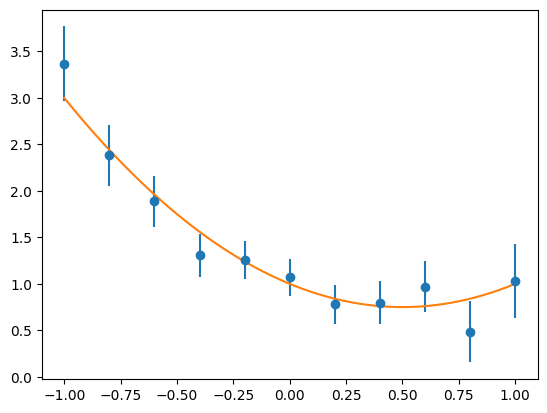

In [4]:
fig = plt.figure()

plt.errorbar(Messpunkte, Datenpunkte, yerr=Messfehler, linestyle='none',fmt='o')
plt.plot(np.linspace(-1,1,1000),Wahres_Polynom(np.linspace(-1,1,1000)))

In [5]:
def LogLikelihood(aj):
    Polynom = lambda x: np.sum([aj[i]*x**i for i in range(len(aj))])
    return np.sum([-(Polynom(Messpunkte[k]) - Datenpunkte[k])**2 / (2 * Messfehler[k]**2)
                  for k in range(len(Messpunkte))])

def Max_LogLikelihood(j = 2):
    result = minimize(lambda x: -2 * LogLikelihood(x), np.ones(j))
    return [result.x, result.fun]

Das Maximum der Likelihood-Funktion wird umso größer, je mehr Parameter im Fit verwendet werden.

For i_max =  0 : log(L_max) =  -31.02307061327007
For i_max =  1 : log(L_max) =  -9.810901623112743
For i_max =  2 : log(L_max) =  -2.041448414200124
For i_max =  3 : log(L_max) =  -1.4577063123727454
For i_max =  4 : log(L_max) =  -1.1794439158935004
For i_max =  5 : log(L_max) =  -1.173359291041256
For i_max =  6 : log(L_max) =  -1.0858795434822148


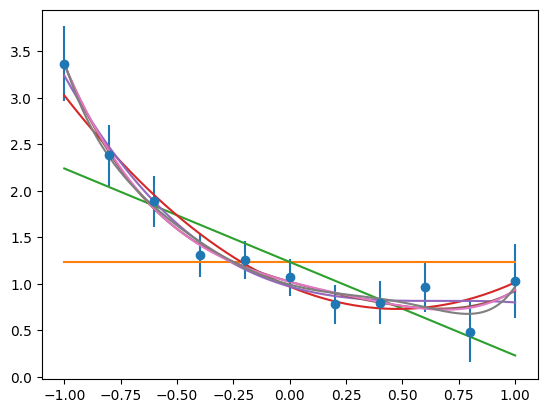

In [6]:
plt.errorbar(Messpunkte, Datenpunkte, yerr=Messfehler, linestyle='none',fmt='o')

for imax in range(7):
    res = Max_LogLikelihood(j = imax + 1)
    print("For i_max = ",imax,": log(L_max) = ", - res[1] / 2.)
    Polynom = lambda x: np.sum([res[0][i] * x**i for i in range(imax + 1)], axis=0)
    
    plt.plot(np.linspace(-1,1,1000),Polynom(np.linspace(-1,1,1000)))

Die Bayes-Evidenz nimmt ab, wenn man zu viele Parameter einführt.

In [7]:
def Bayes_Evidenz(imax = 2, amin = -5., amax = 5.):
    
    ndim = imax
    settings = PolyChordSettings(ndim, 0)
    settings.file_root = 'test_pch'
    settings.nlive = 200
    settings.do_clustering = False
    settings.read_resume = False
    settings.feedback = 0
    
    # Numerische Optimierung
    Hilfsarray_1 = [Messpunkte**i / (np.sqrt(2) * Messfehler) for i in range(imax)]
    Hilfsarray_2 = Datenpunkte / (np.sqrt(2) * Messfehler)
    
    def LogLikelihood(aj):
        logL = np.sum(-(np.dot(aj,Hilfsarray_1) - Hilfsarray_2)**2)
        return logL, []

    def prior(cube):
       return amin + (amax - amin)*cube
    
    res = pypolychord.run_polychord(LogLikelihood, ndim, 0, settings, prior)
    
    return [res.logZ, res.logZerr]

In [8]:
imax = 3
res = Bayes_Evidenz(imax = imax + 1)
print("For i_max = ",imax,": Bayes-Evidenz = ", res[0], "+/-", res[1])


PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.20.1
  release: 1st June 2021
    email: wh260@mrao.cam.ac.uk



hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


 ____________________________________________________ 
|                                                    |
| ndead  =         3977                              |
| log(Z) =          -13.44430 +/-            0.22412 |
|____________________________________________________|
For i_max =  3 : Bayes-Evidenz =  -13.4442982906058 +/- 0.224115056863262
